In [ ]:
#imports
import random
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import networkx as nx
import copy
from google.colab import files
import statistics
from google.colab import drive

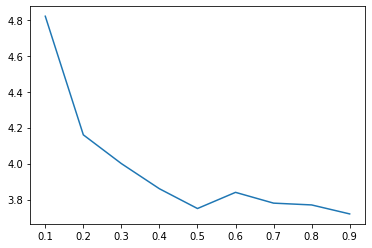

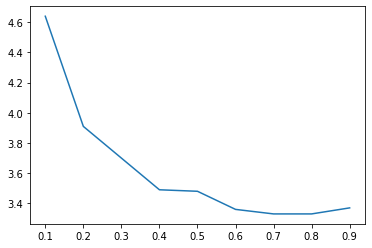

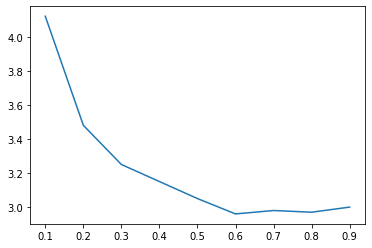

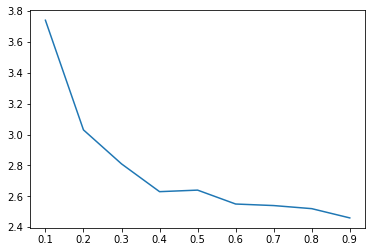

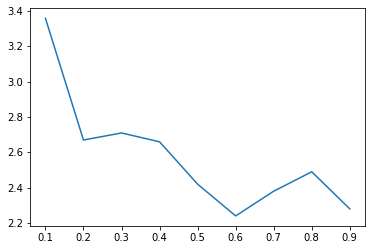

In [ ]:
#testing data
x = [i/10 for i in range(1,10)]
y_0 = [4.12,
3.48,
3.25,
3.15,
3.05,
2.96,
2.98,
2.97,
3]
y_1 = [4.82,
4.16,
4,
3.86,
3.75,
3.84,
3.78,
3.77,
3.72]
y_05 = [4.64,
3.91,
3.7,
3.49,
3.48,
3.36,
3.33,
3.33,
3.37]
y_005 = [3.74,
3.03,
2.81,
2.63,
2.64,
2.55,
2.54,
2.52,
2.46]
y_00999 = [3.36,
2.67,
2.71,
2.66,
2.42,
2.24,
2.38,
2.49,
2.28]
plt.plot(x, y_1)
plt.show()
plt.plot(x, y_05)
plt.show()
plt.plot(x, y_0)
plt.show()
plt.plot(x, y_005)
plt.show()
plt.plot(x, y_00999)
plt.show()



In [ ]:
#util
def frac_greater(arr,data):
  ret = []
  arr = [i for i in arr if math.log10(i) >= low_cutoff]
  for elem in arr:
    ret.append(np.sum(data >= elem) / size)
  for i in range(len(arr)):
    if (ret[i] > 0.1 or ret[i] <0.001):
      ret[i] = -1
      arr[i] = -1
  ret = [i for i in ret if i != -1]
  arr = [i for i in arr if i != -1]
  return ret, arr

def compute_coeff(graph, size, high_cutoff = None, low_cutoff = 0):
  measured_degrees = [i[1] for i in graph.degree()]
  max_deg = max(measured_degrees)
  degrees = list(range(1, max_deg))
  deg_frac, degrees = frac_greater(degrees, np.array(measured_degrees))
  for i in range(len(deg_frac)):
    if (deg_frac[i] == 0):
      degrees[i] = -1
  degrees = [math.log(i) for i in degrees if i != -1]
  deg_frac = [-1 * math.log(i) for i in deg_frac if i != 0]
  a, b = np.polyfit(degrees, deg_frac, 1)
  #measured_degrees.sort(reverse=True)
  return a, measured_degrees

def sort_degrees(graph):
  size = graph.size()
  bins = [[] for x in range(math.ceil(math.log10(size)))]
  degrees = [i[1] for i in graph.degree()]
  for deg in degrees:
    bins[math.floor(math.log10(deg))].append(deg)
  return bins

def output_counts(graph):
  bins = sort_degrees(graph)
  for i in range(len(bins)):
    print(str(pow(10, i)) + " to " + str(pow(10, i + 1)) + ": " + str(len(bins[i])))
  return bins

def initial_nodes(graph, count):
  degrees = graph.degree([i for i in range(count)])
  return degrees

def percents(bins, size):
  for i in range(len(bins)):
    print("bin " + str(i) + " has " + str(100 * len(bins[i])/size) + "% of the total nodes")

In [ ]:
# delay model v3 (100,000 nodes < 1 min)
def barabasi_albert_graph_delay(n, m, a, seed=None):
    if m < 1 or  m >=n:
        raise nx.NetworkXError(\
              "Barabási-Albert network must have m>=1 and m<n, m=%d,n=%d"%(m,n))
    if seed is not None:
        random.seed(seed)
    G=nx.empty_graph(m + 1)
    targets=list(range(m))
    repeated_nodes=[]
    source=m
    while source<n:
        G.add_edges_from(zip([source]*m,targets))
        repeated_nodes.extend(targets)
        repeated_nodes.extend([source]*m)
        delay = min(math.ceil(pow(random.random(), (-1/a))), source - m)
        # delay = 0
        if (delay != 0):
          delay = min(2 * m * delay, len(repeated_nodes) - 1)
          temp_repeated = repeated_nodes[:(len(repeated_nodes) - delay)]
        else:
          temp_repeated = repeated_nodes
        targets = random.sample(temp_repeated,m)
        source += 1
    return G

In [ ]:
#generate picture
drive.mount('/drive')
size = 1000
connections = 1
graph = barabasi_albert_graph_delay(size, connections, 0.2)
with open('Colab Notebooks', 'w') as f:
      f.seek(0)
      f.truncate()
      nx.write_graphml(graph, 'test.graphml')
files.download('test.graphml')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

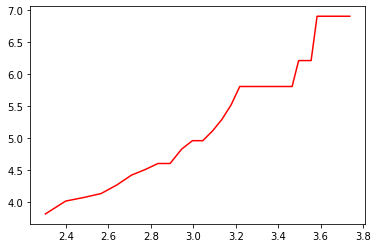

coeff: 2.332288857033559


In [ ]:
#compute and plot single graph coeff
size = 1000
graph = nx.barabasi_albert_graph(size, 1)

measured_degrees = [i[1] for i in graph.degree()]

high_cutoff = 7
low_cutoff = 1

max_deg = max(measured_degrees)
degrees = list(range(1, max_deg))
deg_frac, degrees = frac_greater(degrees, np.array(measured_degrees) )

for i in range(len(deg_frac)):
  if (deg_frac[i] == 0):
    print(deg_frac[i],degrees[i])
    degrees[i] = -1
degrees = [math.log(i) for i in degrees if i != -1]
deg_frac = [-1 * math.log(i) for i in deg_frac if i != 0]

plt.plot(degrees, deg_frac, color='red')
plt.show()
a, b = np.polyfit(degrees, deg_frac, 1)
print("coeff: " + str(a))

In [ ]:
#coeff diff across multiple samples
num_samples = 3
size = 10000
high_cutoff = 4
low_cutoff = 0
connections = 1

delay_coeffs = []
no_delay_coeffs = []

for c in range(num_samples):
  graph_del = barabasi_albert_graph_delay(size, connections, 0.2)
  graph_no_del = nx.barabasi_albert_graph(size, connections)
  d, dmax = compute_coeff(graph_del, size, high_cutoff, low_cutoff)
  delay_coeffs.append(d)
  nd, ndmax = compute_coeff(graph_no_del, size, high_cutoff, low_cutoff)
  no_delay_coeffs.append(nd)

difference = statistics.mean(delay_coeffs) - statistics.mean(no_delay_coeffs)
print("difference: " + str(difference))
print("variance: " + str(statistics.variance(np.subtract(delay_coeffs, no_delay_coeffs))))
print("mean delay coeffs: " + str(statistics.mean(delay_coeffs)))
print("mean no delay coeffs: " + str(statistics.mean(no_delay_coeffs)))


difference: 0.7034444945317564
variance: 0.007600549122884194
mean delay coeffs: 2.5765493120451697
mean no delay coeffs: 1.8731048175134133


In [ ]:
#supernode distribution
size = 10000
connections = 3
g = barabasi_albert_graph_delay(size, connections, 0.2)
bins = output_counts(g)
l = len(bins)
print("last bin: " + str(bins[l - 1]))
print("second to last: " + str(bins[l - 2]))
percents(bins, size)

1 to 10: 9338
10 to 100: 658
100 to 1000: 0
1000 to 10000: 4
10000 to 100000: 0
last bin: []
second to last: [1955, 2026, 1823, 4232]
bin 0 has 93.38% of the total nodes
bin 1 has 6.58% of the total nodes
bin 2 has 0.0% of the total nodes
bin 3 has 0.04% of the total nodes
bin 4 has 0.0% of the total nodes


In [ ]:
#tracking intial nodes
gi = barabasi_albert_graph_delay(10000, 1, 0.2)
print("initial nodes: " + str(initial_nodes(g, 4)))

initial nodes: [(0, 1955), (1, 2026), (2, 1823), (3, 4232)]


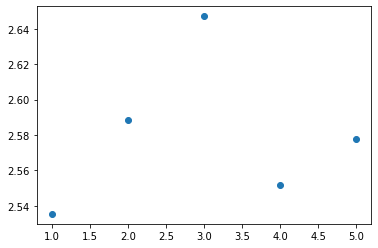

In [ ]:
#coeffs across multiple connections
max_connections = 5
num_samples = 3
graph_size = 10000
coeffs = []

for i in range(max_connections):
  temp_c = []
  for j in range(num_samples):
    g = barabasi_albert_graph_delay(graph_size, i + 1, 0.2)
    c, void = compute_coeff(g, graph_size)
    temp_c.append(c)
  coeffs.append(statistics.mean(temp_c))

x = [i + 1 for i in range(max_connections)]

plt.scatter(x, coeffs)
plt.show()

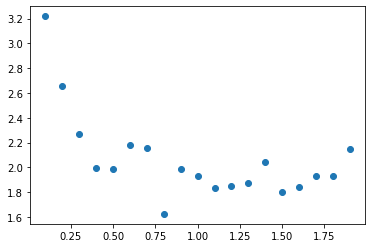

In [ ]:
#coeffs across multiple delays
size = 10000
connections = 1
num_samples = 1
delays = [i / 10.0 for i in range(1, 20)]
coeffs = []
for delay in delays:
  temp_c = []
  for j in range(num_samples):
    g = barabasi_albert_graph_delay(size, connections, delay)
    c, void = compute_coeff(g, size)
    temp_c.append(c)
  coeffs.append(statistics.mean(temp_c))

plt.scatter(delays, coeffs)
plt.show()

(array([6., 2., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39]),
 <a list of 38 Patch objects>)

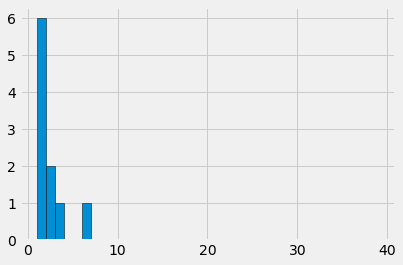

In [ ]:
#delay model v1
NUM_CONNECTIONS = 1
PROB_CONSTANT = 1
NUM_NODES = 10

# graph with delay

# time/node identifier : edges
graph_delay = {
    0 : [],
    1 : [0] * NUM_CONNECTIONS
}


temp_degree_sum = 2 * NUM_CONNECTIONS
temp_graph_size = 2

def indiv_node_degree(n):
  count = 0
  for i in range(n, temp_graph_size):
    if n in graph_delay[i]:
      count += 1
  return count + NUM_CONNECTIONS

def update_deg_sum(size):
  return (size - 1) * 2 * NUM_CONNECTIONS

for i in range(2, NUM_NODES):
  graph_delay[i] = []
  for j in range(NUM_CONNECTIONS):
    r = random.random()
    sum_prob = 0.0
    dvar = 0
    # dvar = math.floor(np.random.uniform(0, 1))
    # dvar = np.random.geometric(0.6)
    delay = min(dvar, len(graph_delay) - 2)
    temp_graph_size = len(graph_delay) - delay - 1
    temp_degree_sum = update_deg_sum(temp_graph_size)
    for n in range(temp_graph_size):
      deg = indiv_node_degree(n)
      sum_prob += (deg + PROB_CONSTANT)/(temp_degree_sum + PROB_CONSTANT * temp_graph_size)
      if (r < sum_prob):
        graph_delay[i].append(n)
        break

temp_graph_size = len(graph_delay)
degrees_del = []
for i in range(temp_graph_size):
  degrees_del.append(indiv_node_degree(i))

plt.style.use('fivethirtyeight')
bins_del = list(range(1, 40))
plt.hist(degrees_del, bins = bins_del, edgecolor = 'black')
 



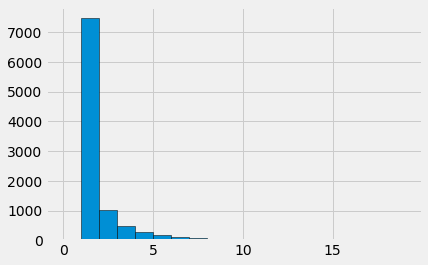

10000


In [ ]:
#delay method v2 (100,000 in 5 mins, 10,000 in 3s)
import networkx as nx
import numpy as np
import math
from matplotlib import pyplot as plt
import copy

size = 10000
connections = 1

graph = nx.Graph()
graph.add_node(0)
graph.add_node(1)
graph.add_edge(0, 1)

degrees_list = [connections] * size

for i in range(2, size):
  for j in range(connections):
    r = np.random.random()
    sum_prob = 0.0
    dvar = 0
    delay = min(dvar, i - 1)
    t_size = i - delay
    for node in range(t_size, i):
      edge = graph.neighbors(node)
      degrees_list[edge[0]] += -1
    for n in range(t_size):
      sum_prob += (degrees_list[n])/((t_size - 1) * 2 * connections)
      if (r < sum_prob):
        graph.add_node(i)
        graph.add_edge(i, n)
        degrees_list[i] += 1
        degrees_list[n] += 1
        break
    for node in range(t_size, i):
      edge = graph.neighbors(node)
      degrees_list[edge[0]] += 1

possible_degrees = list(range(20))
measured_degrees = [i[1] for i in graph.degree()]

plt.style.use('fivethirtyeight')
plt.hist(measured_degrees, bins = possible_degrees, edgecolor = 'black')

plt.show()

print(len(measured_degrees))
